# Hide & Seek — Reporting Notebook




In [3]:
# Setup
from pathlib import Path
import importlib.util
import numpy as np, pandas as pd, matplotlib.pyplot as plt

CWD = Path.cwd()
candidates = [
    CWD / "proyecto" / "HideandSeek.py",          # notebook en raíz ASSIGNMENT1
    CWD / "HideandSeek.py",                       # notebook dentro de proyecto/
    CWD.parent / "proyecto" / "HideandSeek.py",   
]
mod_path = next((p for p in candidates if p.exists()), None)
if not mod_path:
    raise FileNotFoundError(f"No encuentro HideandSeek.py. Probé: {candidates}")

PROJ = mod_path.parent                   
ROOT = PROJ.parent                     
RESULTS = ROOT / "results"
RESULTS.mkdir(exist_ok=True)

# Importa el módulo del proyecto
spec = importlib.util.spec_from_file_location("HideandSeek", str(mod_path))
HS = importlib.util.module_from_spec(spec)
spec.loader.exec_module(HS)

env = HS.HideAndSeekEnv(render_mode=None)

print("Notebook cwd     :", CWD)
print("Module path      :", mod_path)
print("Project dir (PROJ):", PROJ)
print("Results dir      :", RESULTS)
print("Action space     :", getattr(env, "action_space", None))


pygame 2.6.1 (SDL 2.28.4, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html
Notebook cwd     : c:\Users\nico.azcarate\Desktop\AprendizRef\assignment1\proyecto
Module path      : c:\Users\nico.azcarate\Desktop\AprendizRef\assignment1\proyecto\HideandSeek.py
Project dir (PROJ): c:\Users\nico.azcarate\Desktop\AprendizRef\assignment1\proyecto
Results dir      : c:\Users\nico.azcarate\Desktop\AprendizRef\assignment1\results
Action space     : Discrete(4)


c:\Users\nico.azcarate\Desktop\AprendizRef\assignment1\.venv\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists
c:\Users\nico.azcarate\Desktop\AprendizRef\assignment1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Policies and evaluation
import numpy as np
from pathlib import Path

def random_policy(obs):
    return np.random.randint(env.action_space.n)

def greedy_bfs_policy(obs):
    # Acción que minimiza la distancia de camino más corto (BFS) desde la
    # siguiente posición del seeker hasta el hider
    x0, y0 = env.seeker_pos
    best_a, best_d = 0, float("inf")
    for a in range(env.action_space.n):
        nx, ny = env._move((x0, y0), a)
        d = env.shortest_path_distance((nx, ny), env.hider_pos)
        if d < best_d:
            best_d, best_a = d, a
    return best_a

def load_q_table(path: Path):
    arr = np.load(str(path), allow_pickle=True)
    try:
        return arr.item()   
    except Exception:
        return arr          

Q_PATH = PROJ / "q_table_sarsa.npy"
Q = load_q_table(Q_PATH)

def sarsa_greedy_policy(obs):
    s = tuple(obs)
    if isinstance(Q, dict):
        qs = Q.get(s, np.zeros(env.action_space.n))
    else:
        qs = np.zeros(env.action_space.n)
    return int(np.argmax(qs))

def eval_policy(policy_fn, episodes=200, seed=0):
    rng = np.random.RandomState(seed)
    rewards, steps, captured = [], [], []
    for ep in range(episodes):
        obs, info = env.reset(seed=int(rng.randint(0, 1_000_000_000)))
        tot, t = 0.0, 0
        while True:
            a = policy_fn(obs)
            obs, r, term, trunc, _ = env.step(a)
            tot += r; t += 1
            if term or trunc:
                rewards.append(tot)
                steps.append(t)
                captured.append(bool(term))
                break
    return np.array(rewards, float), np.array(steps, int), np.array(captured, bool)

def summarize(rew, steps, cap):
    ok = cap.astype(bool)
    cap_rate = ok.mean()
    avg_steps = steps[ok].mean() if ok.any() else np.nan
    p90_steps = np.percentile(steps[ok], 90) if ok.any() else np.nan
    return {
        "Capture rate": cap_rate,
        "Avg steps (success)": float(avg_steps),
        "P90 steps (success)": float(p90_steps),
        "Avg reward": float(rew.mean()),
    }


## 1) Learning curves

,reward,steps,epsilon,reward_ma,steps_ma
0,-16.18,302,0.220075,NaN,NaN
1,0.74,205,0.078759,NaN,NaN
2,-1.90,400,0.050000,NaN,NaN
3,-8.78,400,0.050000,NaN,NaN
4,0.80,172,0.050000,NaN,NaN


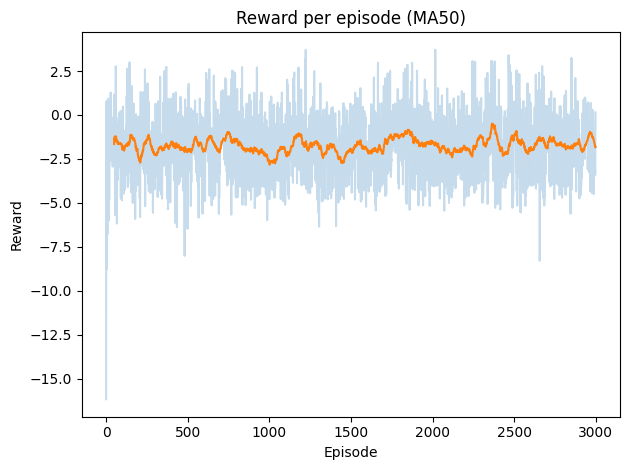

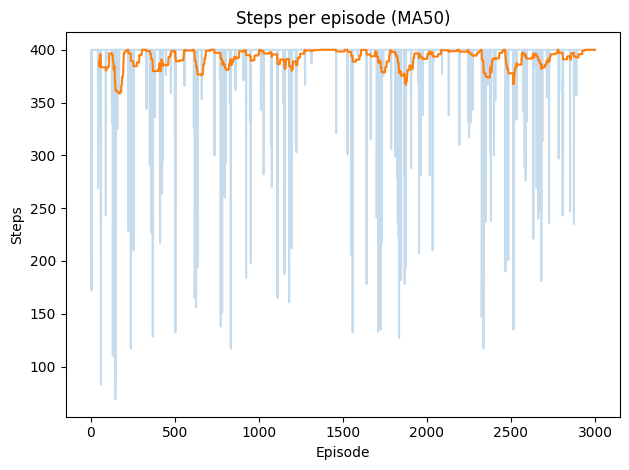

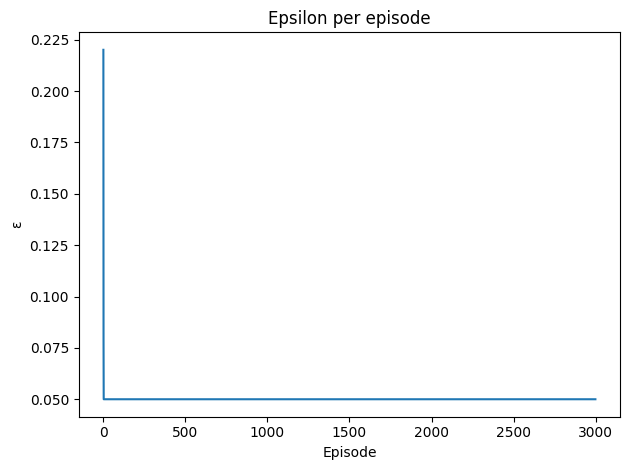

In [11]:
# Learning Curves: reward (MA), steps (MA), epsilon
import numpy as np, pandas as pd, matplotlib.pyplot as plt

EPISODES_TRAIN = 3000      
ALPHA = 0.1
GAMMA = 0.95
EPS = 1.0
EPS_DECAY = 0.995
EPS_MIN = 0.05
MA = 50                   

agent = HS.SARSAAgent(env.action_space.n, alpha=ALPHA, gamma=GAMMA,
                      epsilon=EPS, epsilon_decay=EPS_DECAY, epsilon_min=EPS_MIN)

rewards, steps, epsilons = [], [], []

for ep in range(EPISODES_TRAIN):
    obs, info = env.reset()
    s = tuple(obs)
    a = agent.choose_action(s, env)
    total_r, t = 0.0, 0
    while True:
        obs2, r, term, trunc, _ = env.step(a, hider_action=None, auto_hider=True)
        ns = tuple(obs2)
        na = agent.choose_action(ns, env)
        agent.update(s, a, r, ns, na)
        agent.decay_epsilon()
        s, a = ns, na
        total_r += r; t += 1
        if term or trunc:
            rewards.append(total_r)
            steps.append(t)
            epsilons.append(agent.epsilon)
            break

log = pd.DataFrame({"reward": rewards, "steps": steps, "epsilon": epsilons})
log["reward_ma"] = log["reward"].rolling(MA).mean()
log["steps_ma"]  = log["steps"].rolling(MA).mean()
log.to_csv(str(RESULTS / "training_log_curves.csv"), index=False)
display(log.head())

plt.figure(); plt.plot(log["reward"], alpha=0.25); plt.plot(log["reward_ma"])
plt.title(f"Reward per episode (MA{MA})"); plt.xlabel("Episode"); plt.ylabel("Reward")
plt.tight_layout(); plt.savefig(str(RESULTS / "reward_curve_MA.png"), dpi=160); plt.show()

plt.figure(); plt.plot(log["steps"], alpha=0.25); plt.plot(log["steps_ma"])
plt.title(f"Steps per episode (MA{MA})"); plt.xlabel("Episode"); plt.ylabel("Steps")
plt.tight_layout(); plt.savefig(str(RESULTS / "steps_curve_MA.png"), dpi=160); plt.show()

plt.figure(); plt.plot(log["epsilon"])
plt.title("Epsilon per episode"); plt.xlabel("Episode"); plt.ylabel("ε")
plt.tight_layout(); plt.savefig(str(RESULTS / "epsilon_curve.png"), dpi=160); plt.show()


### Outputs written to `results/`


